In [1]:
# The Base libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import laspy

# The Deep Learning libraries
import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator

In [2]:
#selecting model checkpoint
MODEL = "1. Data/sam_vit_l_0b3195.pth"
#selecting gpu with cuda
USED_D = torch.device('cuda:0')

In [3]:
sam = sam_model_registry["vit_l"](checkpoint = MODEL)

#Cast your model to a specific device (cuda or cpu)
sam.to(device = USED_D)

C:\Users\ROG\anaconda3\envs\GEOSAM\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [4]:
def generate_spherical_image(center_coordinates, point_cloud, colors, resolution_y=500):
    # Translate the point cloud by the negation of the center coordinates
    translated_points = point_cloud - center_coordinates

    # Calculate norms once for efficiency
    norms = np.linalg.norm(translated_points, axis=1)
    
    # Convert 3D point cloud to spherical coordinates
    theta = np.arctan2(translated_points[:, 1], translated_points[:, 0])
    z_normalized = np.clip(translated_points[:, 2] / norms, -1.0, 1.0)
    phi = np.arccos(z_normalized)

    # Map spherical coordinates to pixel coordinates
    resolution_x = 2 * resolution_y
    x = (theta + np.pi) / (2 * np.pi) * resolution_x
    y = phi / np.pi * resolution_y

    # Create the spherical image with RGB channels
    image = np.zeros((resolution_y, resolution_x, 3), dtype=np.uint8)

    # Create the mapping between point cloud and image coordinates
    mapping = np.full((resolution_y, resolution_x), -1, dtype=int)

    # Assign points to the image pixels
    for i in range(len(translated_points)):
        ix = np.clip(int(x[i]), 0, resolution_x - 1)
        iy = np.clip(int(y[i]), 0, resolution_y - 1)
        # Update pixel if it's empty or closer than the current point
        if mapping[iy, ix] == -1 or norms[i] < norms[mapping[iy, ix]]:
            mapping[iy, ix] = i
            image[iy, ix] = colors[i]
    
    return image, mapping


In [5]:
#Loading the las file from the disk
las = laspy.read("1. Data/buowpub_front_face - Cloud.las")

#Transforming to a numpy array
coords = np.vstack((las.x, las.y, las.z))
point_cloud = coords.transpose()

#Gathering the colors
r=(las.red/65535*255).astype(int)
g=(las.green/65535*255).astype(int)
b=(las.blue/65535*255).astype(int)
colors = np.vstack((r,g,b)).transpose()

In [10]:
def sam_masks(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    c_mask=[]
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*1)))
        c_mask.append(img)
    return c_mask

In [6]:
resolution = 1000

#Defining the position in the point cloud to generate a panorama
center_coordinates = [6, 2.5, 2]


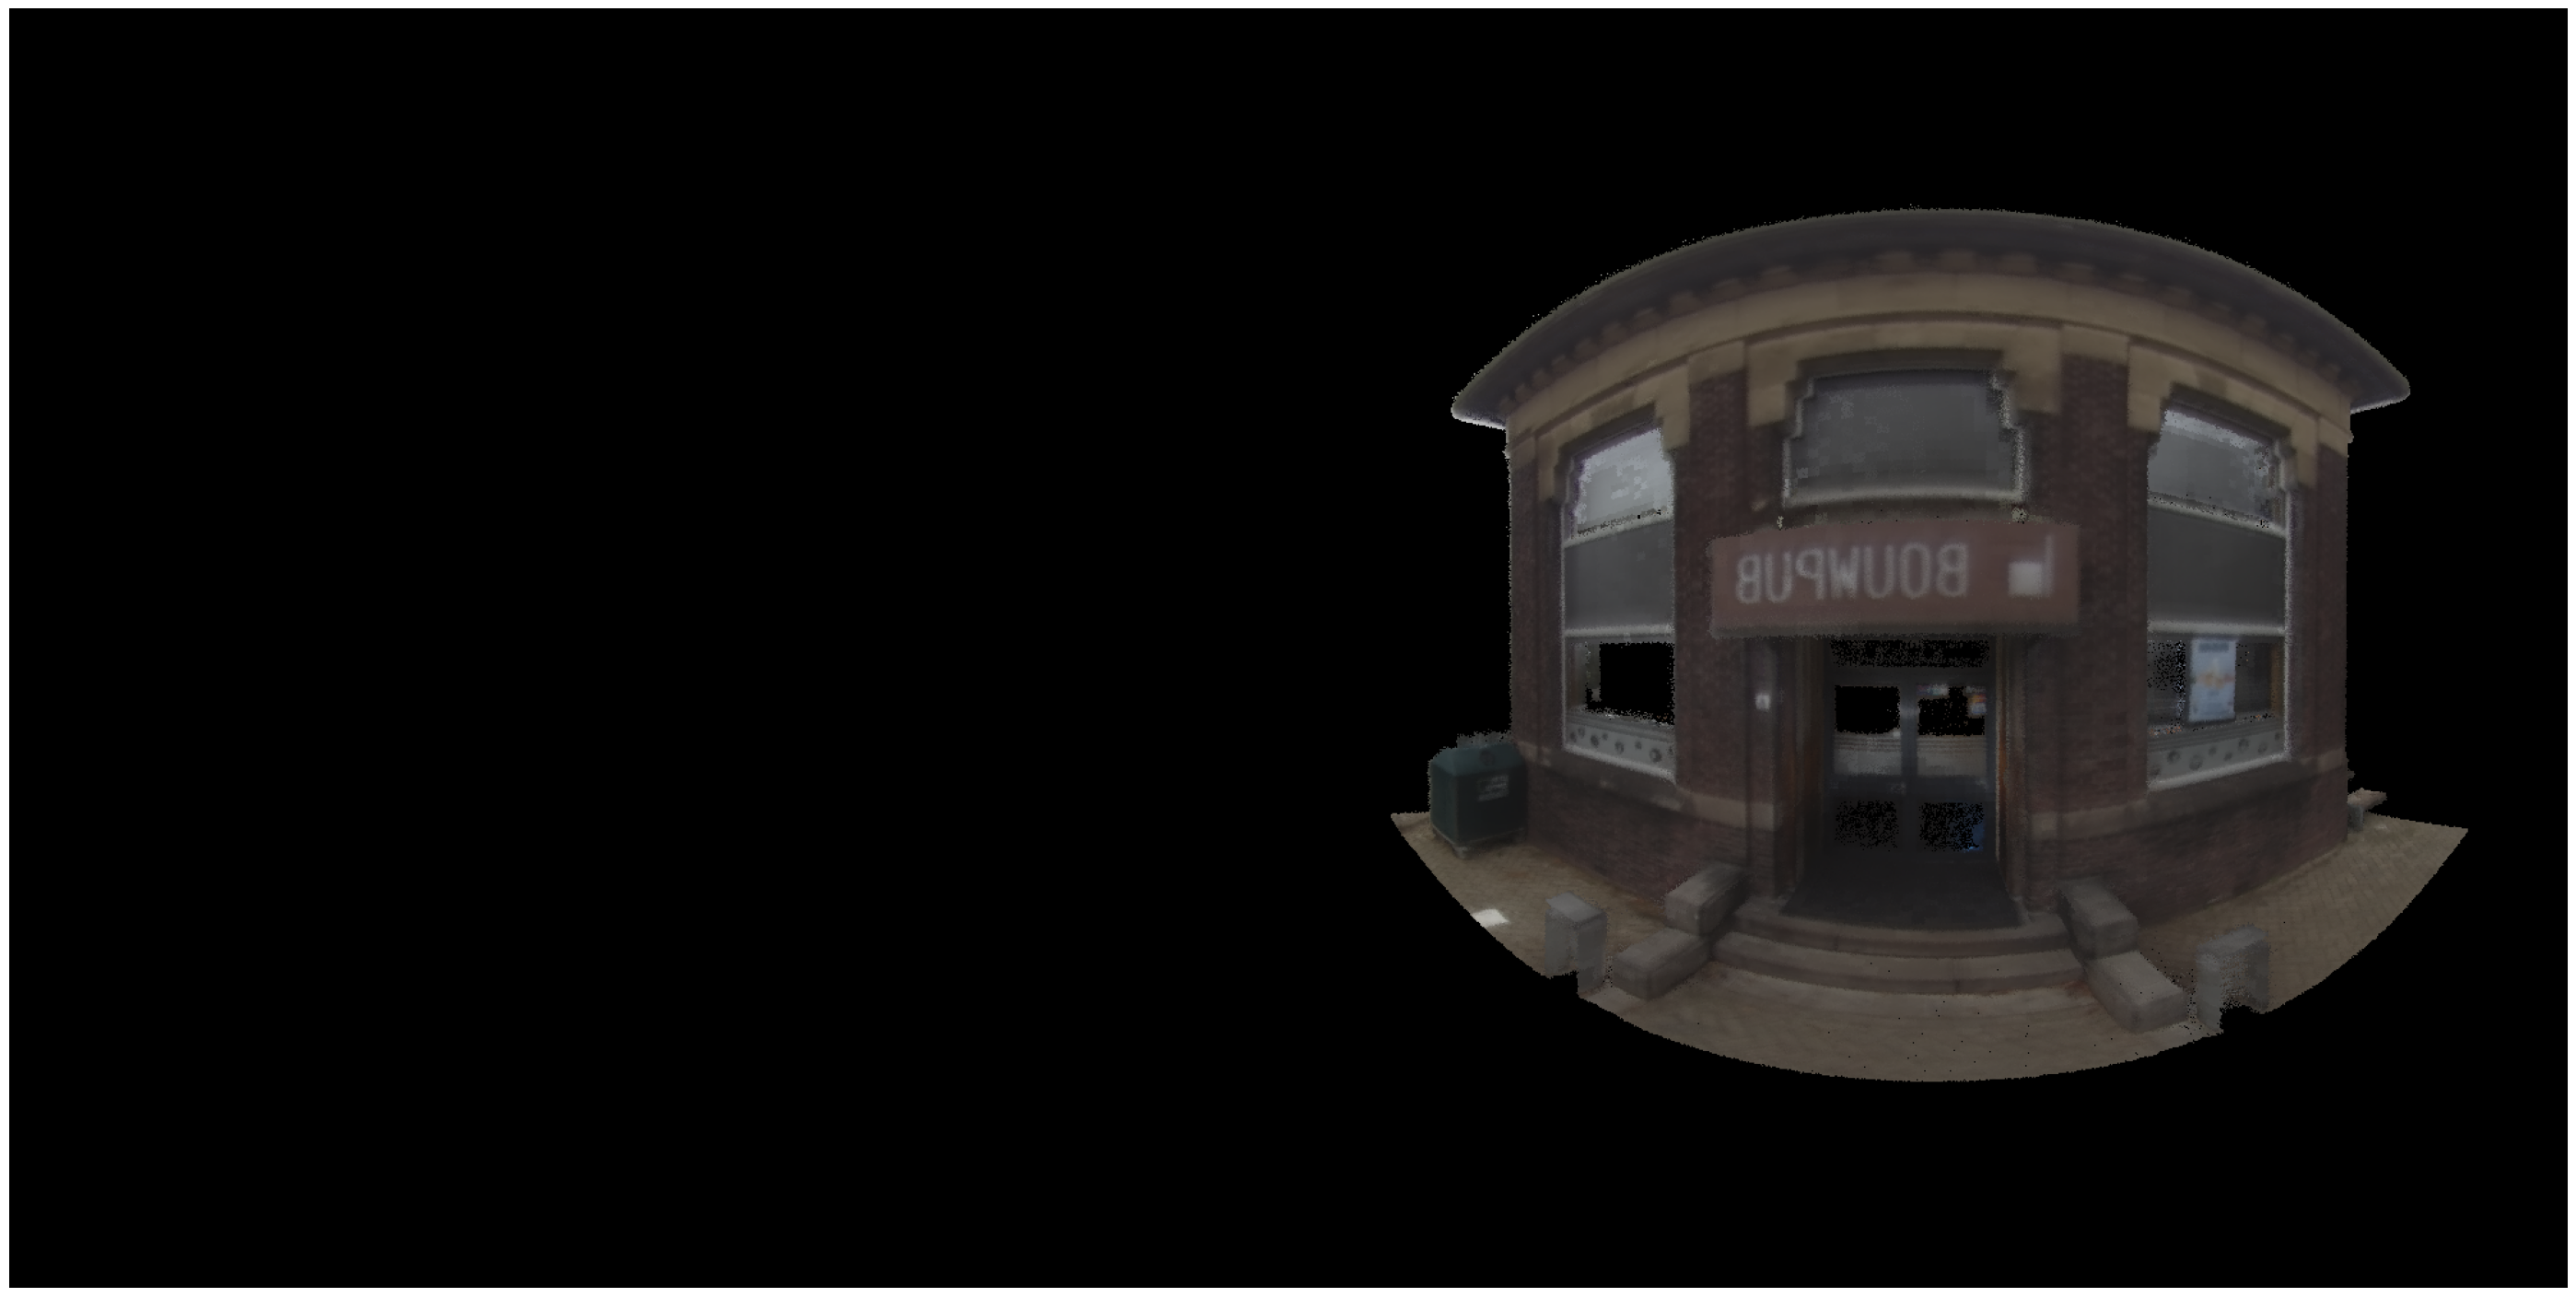

In [7]:
#Function Execution
spherical_image, mapping = generate_spherical_image(center_coordinates, point_cloud, colors, resolution)


#Plotting with matplotlib for front
fig = plt.figure(figsize=(np.shape(spherical_image)[1]/72, np.shape(spherical_image)[0]/72))
fig.add_axes([0,0,1,1])
plt.imshow(spherical_image)
plt.axis('off')

#Saving to the disk
plt.savefig("7. Results/BUILDING_spherical_projection.png", dpi = 72)


In [8]:
sam = sam_model_registry["vit_l"](checkpoint = MODEL)
sam.to(device = USED_D)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,  # Higher resolution for better detail due to the complex features.
    pred_iou_thresh=0.9,  # High threshold to ensure only high-confidence masks are kept.
    stability_score_thresh=0.95,  # High stability to maintain consistent boundaries, especially for architectural elements.
    crop_n_layers=1,  # One layer, as the spherical projection may not need multiple layers for accurate segmentation.
    crop_n_points_downscale_factor=2,  # Standard setting; balances resolution and performance.
    min_mask_region_area=5625  # Slightly larger to avoid noise and capture meaningful structures like windows or signs.
)


temp_img = cv2.imread("7. Results/BUILDING_spherical_projection.png")
image_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)


result = mask_generator.generate(image_rgb)


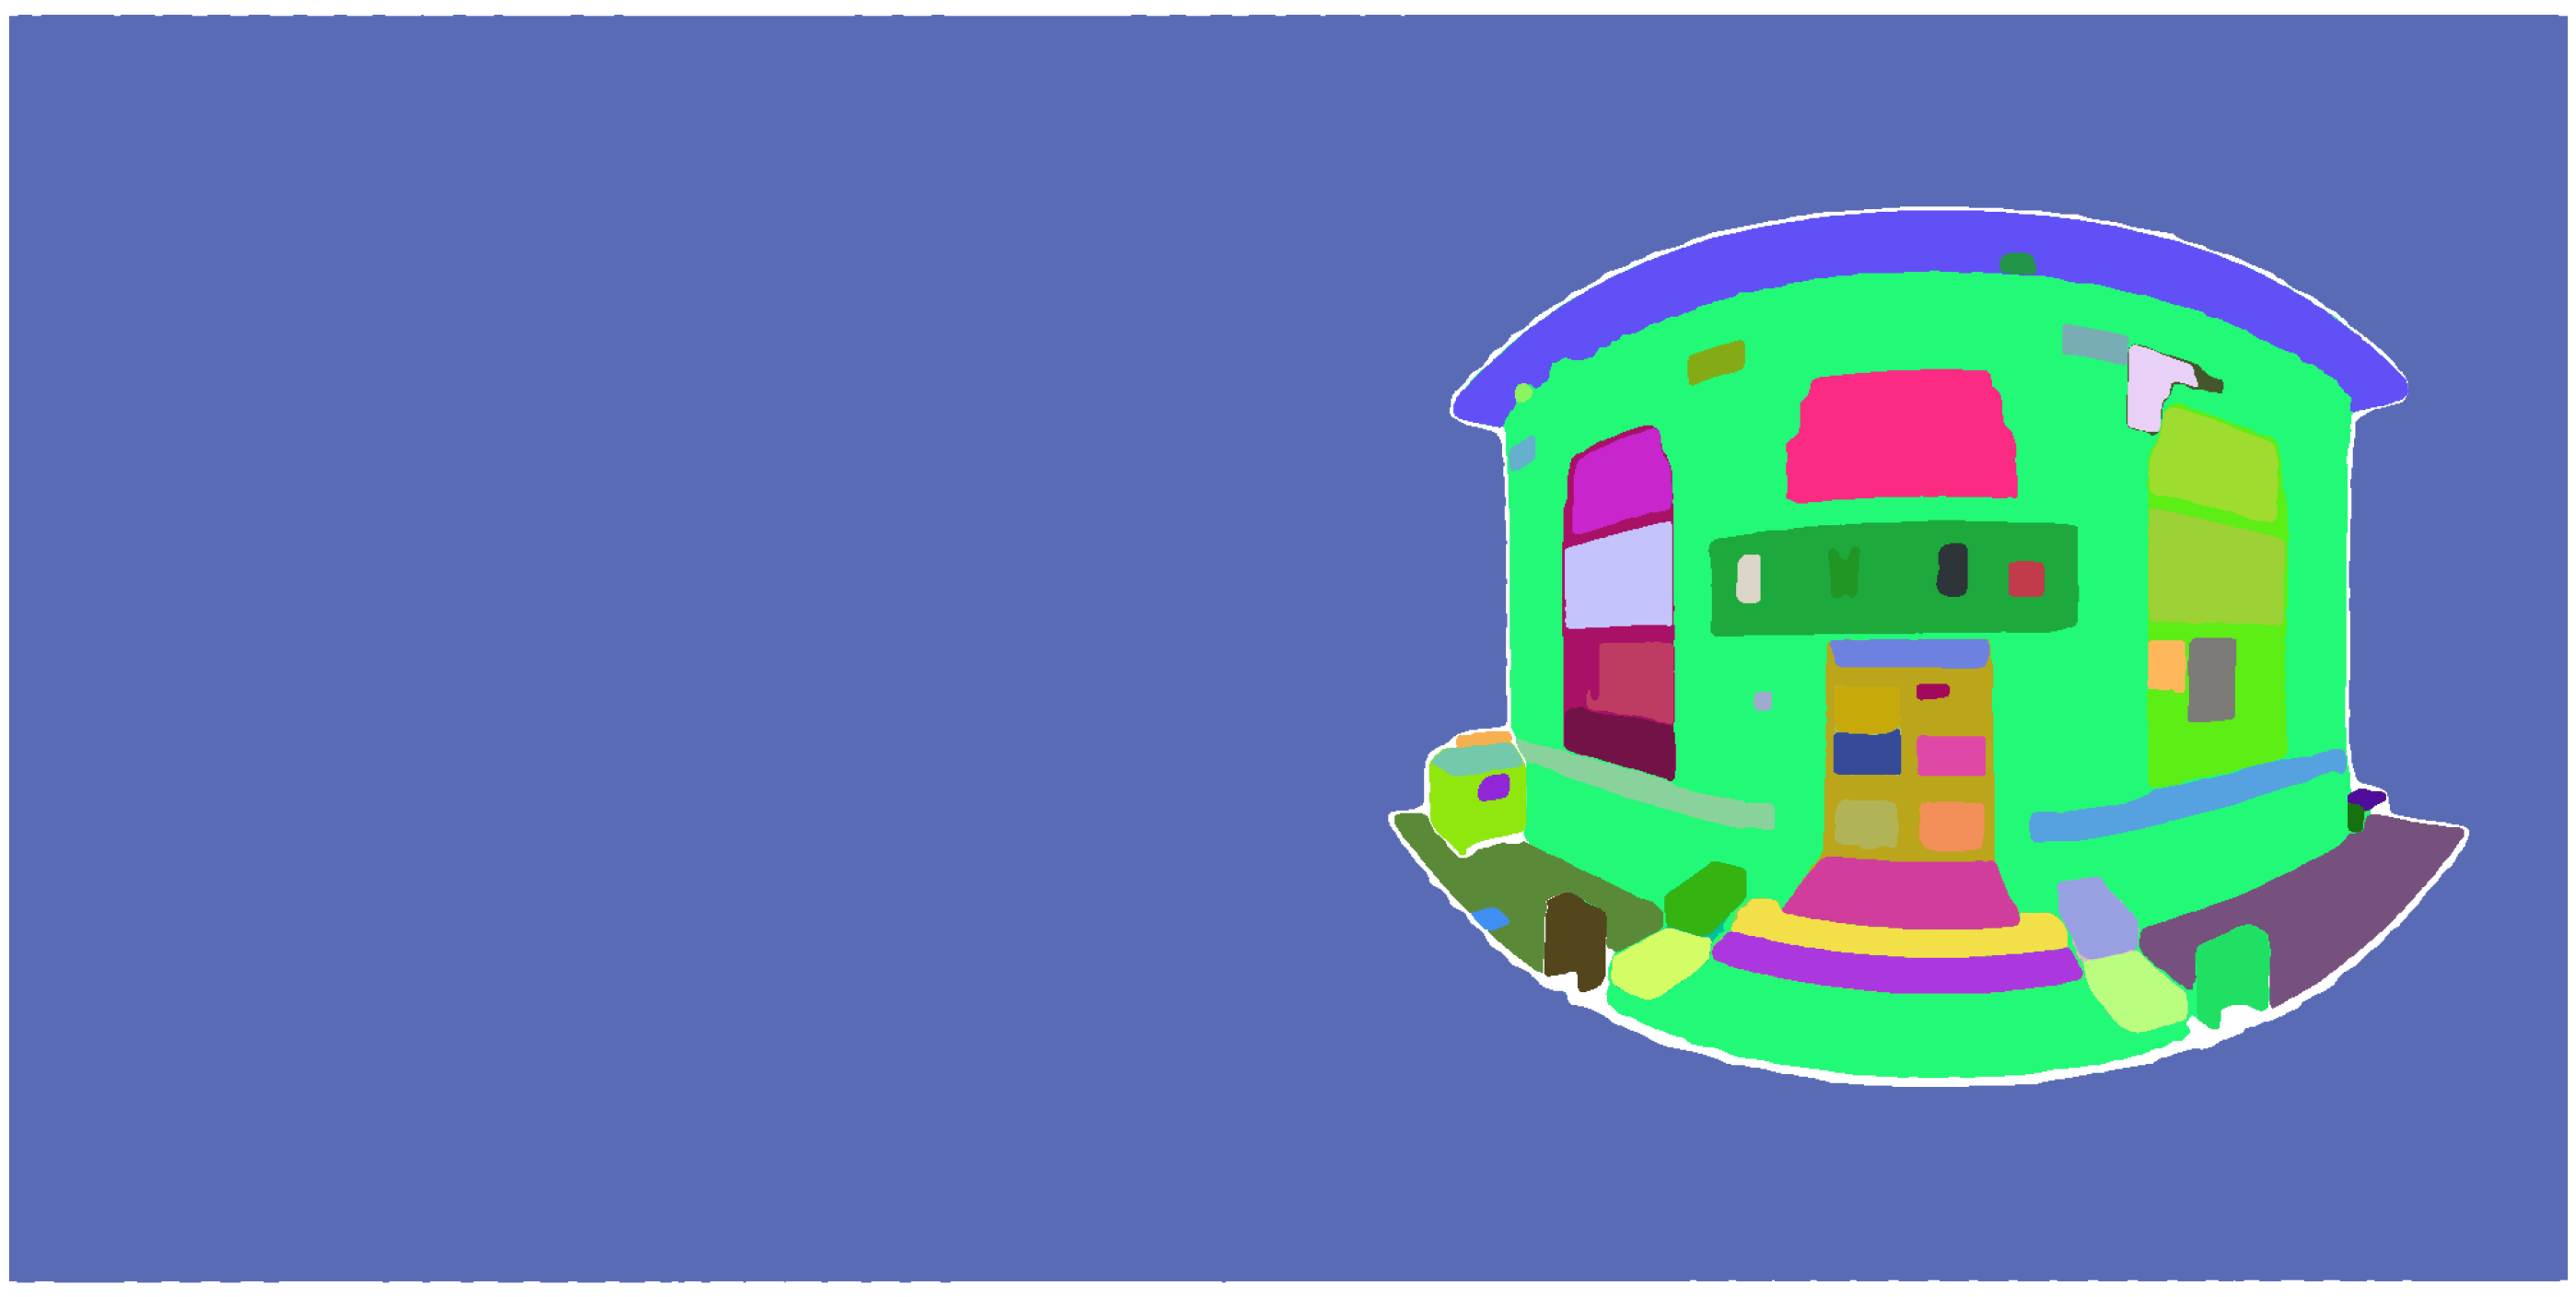

In [11]:
#Plotting it back to img
fig = plt.figure(figsize=(np.shape(image_rgb)[1]/72, np.shape(image_rgb)[0]/72))
fig.add_axes([0,0,1,1])

plt.imshow(image_rgb, alpha = 0)
color_mask = sam_masks(result)
plt.axis('off')
plt.savefig("7. Results/BUILDING_spherical_projection_segmented.png", dpi = 72, bbox_inches='tight', pad_inches=0)


In [13]:

image_path = "7. Results/BUILDING_spherical_projection_segmented.png"
def color_point_cloud(image_path, point_cloud, mapping):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]

    # Create an empty array to store the modified point cloud
    modified_point_cloud = np.zeros((point_cloud.shape[0], point_cloud.shape[1] + 3), dtype=np.float32)
    modified_point_cloud[:, :3] = point_cloud  # Copy the original point cloud

    for iy in range(h):
        for ix in range(w):
            # Clip ix and iy to ensure they don't exceed the bounds
            ix_clipped = np.clip(ix, 0, mapping.shape[1] - 1)
            iy_clipped = np.clip(iy, 0, mapping.shape[0] - 1)

            point_index = mapping[iy_clipped, ix_clipped]

            if point_index != -1:  # Ensure the point is valid
                color = image[iy_clipped, ix_clipped]
                modified_point_cloud[point_index, 3:] = color  # Assign color to the point cloud
                # print(f"Assigned color {color} to point index {point_index}")

    return modified_point_cloud

In [14]:
modified_point_cloud = color_point_cloud(image_path, point_cloud, mapping)

In [15]:
def export_point_cloud(cloud_path, modified_point_cloud):
    # 1. Create a new header
    header = laspy.LasHeader(point_format=3, version="1.2")
    header.add_extra_dim(laspy.ExtraBytesParams(name="color_label", type=np.int32))

    # 2. Create a Las
    las_o = laspy.LasData(header)
    las_o.x = modified_point_cloud[:, 0]
    las_o.y = modified_point_cloud[:, 1]
    las_o.z = modified_point_cloud[:, 2]
    las_o.red = modified_point_cloud[:, 3]
    las_o.green = modified_point_cloud[:, 4]
    las_o.blue = modified_point_cloud[:, 5]
    
    # Find all unique colors in the point cloud
    unique_colors, indices = np.unique(modified_point_cloud[:, 3:6], axis=0, return_inverse=True)
    
    # Create a mapping of unique colors to labels
    color_mapping = {tuple(color): i + 1 for i, color in enumerate(unique_colors)}
    
    # Assign labels based on the color mapping
    color_labels = np.array([color_mapping[tuple(rgb)] for rgb in modified_point_cloud[:, 3:6]])
    
    # Assign the color labels to the extra dimension
    las_o.color_label = color_labels
    
    # Write to file
    las_o.write(cloud_path)
    
    print("Export successful at:", cloud_path)

In [16]:
export_point_cloud("7. Results/pcd_results_final2.las", modified_point_cloud)

Export successful at: pcd_results_final2.las
